# ---------- POC -----------
# Phase 1 - Ensembling LSTM and RF to predict in-hospital mortality

In the POC stage, we have explored the feasibility of using LSTM to handle time series data of some high temporal data and ensembled with random forest classifier trained on other features to predict in-hospital mortality in Phase 1. This notebook presents some of the findings based on 6-hour ICU data.

* Part 1. LSTM for time series data
* Part 2. RandomForestClassifier

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
#from utils import connect_db

---
## Part 1. LSTM for time series data

First, we define the following types of features. We will train one LSTM model for each feature in timeseries_features  separately in Part 1. Then we will combine the predict proba resulted from the LSTM models with other features in catergorial_feature and aggregated_features, and train a random forest classifier to predict the in-hospital mortality in Part 2.

In [9]:
# define features
timeseries_features = ['heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'spo2']
categorical_features = ['gender', 'ethnicity', 'admission_type']
aggregated_features = ['age', 'icustay_num',
                       'tempc_mean', 'glucose_mean', 
                       'tempc_min',  'glucose_min',
                       'tempc_max',  'glucose_max', 
                       'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
                       'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
                       'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
                       'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
                       'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
                       'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
                       'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
                       'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
                       'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
                       'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
                       'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
                       'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
                       'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
                       'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
                       'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
                       'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
                       'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
                       'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
                       'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
                       'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
                       'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
                       'urineoutput']

Next, we will prepare the time series data for fitting LSTM model.

In [10]:
df = pd.read_csv('mp_lstm.csv')
print(df.shape)
df.head()

(1073667, 9)


,icustay_id,hr,heartrate,sysbp,diasbp,meanbp,resprate,spo2,hospital_expire_flag
0,200001,0,113.0,110.0,65.0,76.0,20.0,97.0,0
1,200001,1,108.0,113.0,68.0,79.0,18.0,98.0,0
2,200001,2,110.0,116.0,68.0,79.0,27.0,98.0,0
3,200001,3,102.0,102.0,61.0,71.0,21.0,96.0,0
4,200001,4,108.0,103.0,58.0,69.0,19.0,94.0,0


In [11]:
# load time series data

# impute missing values of numerical features with median
for col in timeseries_features:
    df[col].fillna(df[col].median(), inplace=True)
    
# split data into train, validation and test set
id_train, id_test = train_test_split(df.icustay_id.unique(), test_size=0.2, random_state=0)
id_train, id_val = train_test_split(id_train, test_size=0.2, random_state=0)
id_train.sort()
id_val.sort()
id_test.sort()
print('Train-test-validation split:', id_train.shape[0], id_val.shape[0], id_test.shape[0])

# mortality label
labels = df[['icustay_id', 'hospital_expire_flag']].drop_duplicates()

# pivoting to construct 6-hour time series for each feature
df_timeseries = {}
for feature in timeseries_features :
    df_tmp = df.pivot(index='icustay_id', columns='hr', values=feature)
    df_tmp = labels.merge(df_tmp, left_on='icustay_id', right_index=True, how='inner')
    df_tmp = df_tmp.fillna(0)
    df_timeseries[feature] = df_tmp
    print(feature, df_timeseries[feature].shape)

df_timeseries['heartrate'].head()

Train-test-validation split: 31833 7959 9949
heartrate (49741, 27)
sysbp (49741, 27)
diasbp (49741, 27)
meanbp (49741, 27)
resprate (49741, 27)
spo2 (49741, 27)


,icustay_id,hospital_expire_flag,0,1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,24
0,200001,0,113.0,108.0,110.0,102.0,108.0,104.0,93.0,88.0,...,106.0,111.0,100.0,103.0,98.0,97.0,95.0,94.0,91.0,95.0
25,200003,0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,...,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0
50,200006,0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,...,84.0,84.0,84.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0
69,200007,0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,...,84.0,84.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,200009,0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,...,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0


Now, we are ready to train LSTM on the time series data. We define 2 methods to train LSTM and make prediction.

In [12]:
 def train_lstm(df_train, df_val):
    X_train = df_train.drop(columns=['icustay_id','hospital_expire_flag'])
    y_train = df_train.hospital_expire_flag
    X_val = df_val.drop(columns=['icustay_id','hospital_expire_flag'])
    y_val = df_val.hospital_expire_flag

    X_train = np.array(X_train)
    X_val = np.array(X_val)
    
    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
    #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    feature_dim = X_train.shape[2]
    timesteps = X_train.shape[1]
    
    # build model
    model = Sequential()
    model.add(LSTM(32,input_shape=(timesteps, feature_dim)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer="rmsprop",  metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=0)

    # evaluate on validation set
    score = model.evaluate(X_val, y_val, batch_size=128) #return loss and metric value
    print('Accuracy on validation set = ', score[1])
            
    return model


def predict_lstm(df, model):
    X = df.drop(columns=['icustay_id','hospital_expire_flag'])
    y = df.hospital_expire_flag
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    y_pred_proba = model.predict(X)
    return y_pred_proba


# train one LSTM model for each feature separately 
models = {} 
for f in timeseries_features:
    df_train = df_timeseries[f][df_timeseries[f].icustay_id.isin(id_train)]
    df_val = df_timeseries[f][df_timeseries[f].icustay_id.isin(id_val)]
    print('Training LSTM for feature', f)
    models[f] = train_lstm(df_train, df_val)
    
    
# predict for training set, validation set using trained LSTM 
df_ts_train = labels[labels.icustay_id.isin(id_train)].sort_values(by=['icustay_id'])
df_ts_val = labels[labels.icustay_id.isin(id_val)].sort_values(by=['icustay_id'])

for f in timeseries_features:
    df_train = df_timeseries[f][df_timeseries[f].icustay_id.isin(id_train)].sort_values(by=['icustay_id'])
    df_ts_train[f] = predict_lstm(df_train, models[feature])
    df_val = df_timeseries[f][df_timeseries[f].icustay_id.isin(id_val)].sort_values(by=['icustay_id'])
    df_ts_val[f] = predict_lstm(df_val, models[feature])

Training LSTM for feature heartrate
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
7959/7959 [==============================] - 0s 9us/step
Accuracy on validation set =  0.8866691589355469
Training LSTM for feature sysbp
7959/7959 [==============================] - 0s 11us/step
Accuracy on validation set =  0.8866691589355469
Training LSTM for feature diasbp
7959/7959 [==============================] - 0s 12us/step
Accuracy on validation set =  0.8866691589355469
Training LSTM for feature meanbp
7959/7959 [==============================] - 0s 14us/step
Accuracy on validation set =  0.8866691589355469
Training LSTM for feature resprate
7959/7959 [==============================] - 0s 15us/step
Accuracy on validation set =  0.8866691589355469
Training LSTM for feature spo2
7959/7959 [==============================] - 0s 17us/step
Accuracy on validation set =  0.8866691589355469


---
## Part 2. RandomForestClassifier

In this part, we will use the prediction proba resulted from the LSTM model in Part 1, and combine them with other aggregated/static features to train a ranom forest classifier. First, we define a method which comes handy for us to evaluate the model later.

In [13]:
def evaluate(y_true, y_pred, y_pred_proba):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)   
    print ("Accuracy : {:.4f}".format(acc))
    print("AUC score : {:.4f}".format(auc))
    print("Precision : {:.4f}".format(precision))
    print("Recall : {:.4f}".format(recall))
    print("F1 score : {:.4f}".format(f1score))
    print("\nClassification report : \n", classification_report(y_true, y_pred))
    print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))
    return acc, auc, precision, recall, f1score

In [15]:
# load aggregated/static data
df_6hr = pd.read_csv('mp_data_6hr.csv')

# impute missing values of numerical features with median
for col in aggregated_features:
    df_6hr[col].fillna(df_6hr[col].median(), inplace=True)
    
# encoding categorical features
le_gender = LabelEncoder()
df_6hr['gender'] = le_gender.fit_transform(df_6hr.gender)
le_enthnicity = LabelEncoder()
df_6hr['ethnicity'] = le_enthnicity.fit_transform(df_6hr.ethnicity)
le_admission_type = LabelEncoder()
df_6hr['admission_type'] = le_admission_type.fit_transform(df_6hr.admission_type)

# train-test split (note that we should use the same split using icustay_id as in Part 1)
df_agg = df_6hr[['icustay_id'] + categorical_features + aggregated_features]
df_agg_train = df_agg[df_agg.icustay_id.isin(id_train)].sort_values(by=['icustay_id'])
df_agg_val = df_agg[df_agg.icustay_id.isin(id_val)].sort_values(by=['icustay_id'])

# merge aggregated/static features and the pred proba of time series features resulted from LSTM
data_train = df_ts_train.merge(df_agg_train, left_on='icustay_id', right_on='icustay_id', how='inner')
data_val = df_ts_val.merge(df_agg_val, left_on='icustay_id', right_on='icustay_id', how='inner')

# train random forest on all features
y_train = data_train.hospital_expire_flag
X_train = data_train.drop(columns=['icustay_id','hospital_expire_flag'])
y_val = data_val.hospital_expire_flag
X_val = data_val.drop(columns=['icustay_id','hospital_expire_flag'])
                        
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

# make prediction
y_pred = clf.predict(X_val)
y_pred_proba = clf.predict_proba(X_val)

y_proba = []
for i in range(len(y_pred_proba)):
    y_proba.append(y_pred_proba[i][1])
    
# evaluate the model
evaluate(y_val, y_pred, y_proba)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy : 0.8979
AUC score : 0.7814
Precision : 0.6667
Recall : 0.1973
F1 score : 0.3045

Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.99      0.94      7057
           1       0.67      0.20      0.30       902

    accuracy                           0.90      7959
   macro avg       0.79      0.59      0.62      7959
weighted avg       0.88      0.90      0.87      7959


Confusion matrix : 
 [[6968   89]
 [ 724  178]]


(0.8978514888805126,
 0.781380991087147,
 0.6666666666666666,
 0.1973392461197339,
 0.3045337895637296)

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = roc_auc_score(y_val, y_proba)

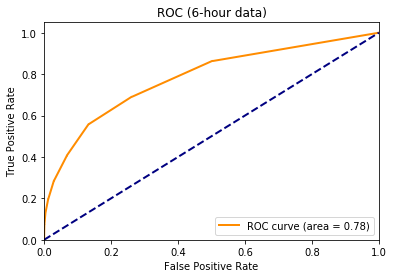

In [20]:
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (6-hour data)')
plt.legend(loc="lower right")